In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from textblob import TextBlob
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

### 1. Preprocessing the Data

For text classification tasks, the first step is preprocessing the data to convert raw text into a format suitable for the model. This involves tokenizing the text and creating appropriate input tensors.

In [2]:
df = pd.read_csv('dataset/analyst_ratings_processed.csv')
df.head()

,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A


In [3]:
df.shape

(1400469, 4)

In [4]:
# This much data will take about 60 hours to fine-tune on my laptop
# Let's trim to 1% of the data
df = df.sample(frac=0.01, random_state=42)
df.shape

(14005, 4)

In [5]:
# Function to determine sentiment
def get_sentiment(title):
    analysis = TextBlob(title)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply the function to our dataset
tqdm.pandas()
# df['sentiment'] = df['title'].apply(get_sentiment)
df['sentiment'] = df['title'].progress_apply(get_sentiment)
df.head()

100%|██████████| 14005/14005 [00:00<00:00, 14885.49it/s]


,Unnamed: 0,title,date,stock,sentiment
951347,963395.0,Top Stocks In The Surety & Title Insurance Ind...,2010-04-13 05:00:00-04:00,ORI,Positive
98223,102011.0,Asterias Provides 6 Mo. Data Readout From Its ...,2018-07-17 07:05:00-04:00,AST,Neutral
940133,952152.0,ONEOK Partners to Participate in Bakken Day,2010-08-04 16:22:00-04:00,OKS,Neutral
185334,189463.0,Shares of Broadsoft to Resume Trade at 4:35PM EST,2013-11-04 16:12:00-05:00,BSFT,Neutral
524898,535387.0,"Courier Corp Holder Gamco Reports 6.97%, Up Fr...",2015-03-30 16:20:00-04:00,GBL,Neutral


In [9]:
# Count how many positive, negative and neutral sentiments we have
df['sentiment'].value_counts()

sentiment
Neutral     9406
Positive    3310
Negative    1289
Name: count, dtype: int64

<Axes: ylabel='count'>

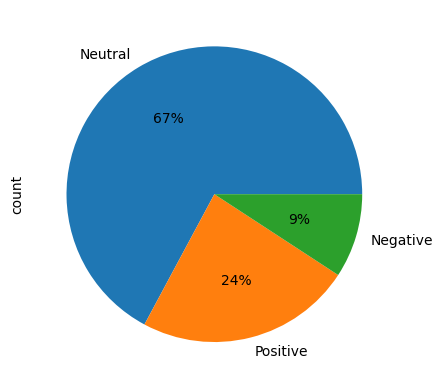

In [10]:
# Plot as a pie chart via matplotlib
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

In [11]:
# Load the pre-trained RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/Users/odai/5588-assignment-2-1/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
# Tokenization function
def tokenize_data(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')

# Tokenize the data
encoded_texts = encoded_texts = [tokenize_data(text) for text in tqdm(df['title'], desc="Tokenizing data")]

Tokenizing data: 100%|██████████| 14005/14005 [00:02<00:00, 5955.00it/s]


### 2. Fine-Tuning RoBERTa

Fine-tuning involves adjusting the weights of a pre-trained model on the specific dataset. 

In [13]:
# Label encoding (convert labels to integers)
label_dict = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
df['label'] = df['sentiment'].replace(label_dict)
df.head()

/var/folders/d4/ggny_vpn0nv4f9ys1m85vyv80000gn/T/ipykernel_56247/591822293.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['sentiment'].replace(label_dict)


,Unnamed: 0,title,date,stock,sentiment,label
951347,963395.0,Top Stocks In The Surety & Title Insurance Ind...,2010-04-13 05:00:00-04:00,ORI,Positive,0
98223,102011.0,Asterias Provides 6 Mo. Data Readout From Its ...,2018-07-17 07:05:00-04:00,AST,Neutral,1
940133,952152.0,ONEOK Partners to Participate in Bakken Day,2010-08-04 16:22:00-04:00,OKS,Neutral,1
185334,189463.0,Shares of Broadsoft to Resume Trade at 4:35PM EST,2013-11-04 16:12:00-05:00,BSFT,Neutral,1
524898,535387.0,"Courier Corp Holder Gamco Reports 6.97%, Up Fr...",2015-03-30 16:20:00-04:00,GBL,Neutral,1


In [14]:
# Prepare dataset for the model
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
# Split data into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(df['title'], df['label'], test_size=0.1)

In [16]:
# Tokenize and create datasets
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)
train_dataset = NewsDataset(train_encodings, train_labels.tolist())
val_dataset = NewsDataset(val_encodings, val_labels.tolist())

In [17]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"
)

/Users/odai/5588-assignment-2-1/.venv/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# Initialize Trainer
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_dict))
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

# Train the model
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4728 [00:00<?, ?it/s]

{'loss': 1.0834, 'grad_norm': 5.397334098815918, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 1.049, 'grad_norm': 3.08414363861084, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'loss': 1.0644, 'grad_norm': 1.2270454168319702, 'learning_rate': 3e-06, 'epoch': 0.02}
{'loss': 1.0096, 'grad_norm': 3.109942674636841, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.03}
{'loss': 1.0251, 'grad_norm': 7.771566390991211, 'learning_rate': 5e-06, 'epoch': 0.03}
{'loss': 0.95, 'grad_norm': 5.016153335571289, 'learning_rate': 6e-06, 'epoch': 0.04}
{'loss': 0.7718, 'grad_norm': 8.170744895935059, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.04}
{'loss': 0.6873, 'grad_norm': 5.816216468811035, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.05}
{'loss': 0.7274, 'grad_norm': 13.856237411499023, 'learning_rate': 9e-06, 'epoch': 0.06}
{'loss': 0.7264, 'grad_norm': 21.665681838989258, 'learning_rate': 1e-05, 'epoch': 0.06}
{'loss': 0.8538, 'grad_norm': 6.5460562

  0%|          | 0/88 [00:00<?, ?it/s]

{'eval_loss': 0.19840466976165771, 'eval_runtime': 14.4633, 'eval_samples_per_second': 96.866, 'eval_steps_per_second': 6.084, 'epoch': 1.0}
{'loss': 0.3217, 'grad_norm': 0.1599254608154297, 'learning_rate': 3.722800378429518e-05, 'epoch': 1.0}
{'loss': 0.3047, 'grad_norm': 0.2134741097688675, 'learning_rate': 3.710974456007569e-05, 'epoch': 1.01}
{'loss': 0.2711, 'grad_norm': 3.5522491931915283, 'learning_rate': 3.69914853358562e-05, 'epoch': 1.02}
{'loss': 0.0895, 'grad_norm': 3.1746857166290283, 'learning_rate': 3.687322611163671e-05, 'epoch': 1.02}
{'loss': 0.1839, 'grad_norm': 0.1425173431634903, 'learning_rate': 3.675496688741722e-05, 'epoch': 1.03}
{'loss': 0.2856, 'grad_norm': 0.13498064875602722, 'learning_rate': 3.6636707663197735e-05, 'epoch': 1.03}
{'loss': 0.3094, 'grad_norm': 6.971884727478027, 'learning_rate': 3.6518448438978244e-05, 'epoch': 1.04}
{'loss': 0.1101, 'grad_norm': 4.386616230010986, 'learning_rate': 3.6400189214758754e-05, 'epoch': 1.05}
{'loss': 0.4919, 'g

  0%|          | 0/88 [00:00<?, ?it/s]

{'eval_loss': 0.17510956525802612, 'eval_runtime': 15.7439, 'eval_samples_per_second': 88.987, 'eval_steps_per_second': 5.589, 'epoch': 2.0}
{'loss': 0.3638, 'grad_norm': 3.8635971546173096, 'learning_rate': 1.8543046357615895e-05, 'epoch': 2.01}
{'loss': 0.0081, 'grad_norm': 4.047372341156006, 'learning_rate': 1.8424787133396408e-05, 'epoch': 2.01}
{'loss': 0.1157, 'grad_norm': 0.18927793204784393, 'learning_rate': 1.8306527909176914e-05, 'epoch': 2.02}
{'loss': 0.1767, 'grad_norm': 0.26437970995903015, 'learning_rate': 1.8188268684957427e-05, 'epoch': 2.02}
{'loss': 0.2062, 'grad_norm': 3.483210563659668, 'learning_rate': 1.807000946073794e-05, 'epoch': 2.03}
{'loss': 0.1049, 'grad_norm': 0.07677116245031357, 'learning_rate': 1.795175023651845e-05, 'epoch': 2.04}
{'loss': 0.0889, 'grad_norm': 5.6795220375061035, 'learning_rate': 1.7833491012298962e-05, 'epoch': 2.04}
{'loss': 0.0918, 'grad_norm': 0.1706928014755249, 'learning_rate': 1.771523178807947e-05, 'epoch': 2.05}
{'loss': 0.23

  0%|          | 0/88 [00:00<?, ?it/s]

{'eval_loss': 0.1433848887681961, 'eval_runtime': 16.8721, 'eval_samples_per_second': 83.037, 'eval_steps_per_second': 5.216, 'epoch': 3.0}
{'train_runtime': 2113.6269, 'train_samples_per_second': 17.89, 'train_steps_per_second': 2.237, 'train_loss': 0.28229128684952554, 'epoch': 3.0}


TrainOutput(global_step=4728, training_loss=0.28229128684952554, metrics={'train_runtime': 2113.6269, 'train_samples_per_second': 17.89, 'train_steps_per_second': 2.237, 'total_flos': 1923702364378872.0, 'train_loss': 0.28229128684952554, 'epoch': 3.0})

### 3. Evaluation

After training, we evaluate via the validation set to see how well it performs.

In [19]:
results = trainer.evaluate()
print(results)

  0%|          | 0/88 [00:00<?, ?it/s]

{'eval_loss': 0.1433848887681961, 'eval_runtime': 13.7504, 'eval_samples_per_second': 101.888, 'eval_steps_per_second': 6.4, 'epoch': 3.0}


In [24]:
# Convert eval_loss to accuracy
accuracy = 1 - results['eval_loss']
print(accuracy)

0.8566151112318039
